# Google Colab Troubleshooting Guide

## If your notebook is not running, try these steps:

1. **Check Runtime Connection**
   - Look at the top right corner of Colab
   - If it says "Not connected" or "Disconnected", click "Connect" or go to: **Runtime → Connect to runtime**

2. **Enable GPU**
   - Go to: **Runtime → Change runtime type → Hardware accelerator: GPU → Save**
   - This is REQUIRED for this diffusion model to work properly

3. **Restart Runtime** (if cells are stuck)
   - Go to: **Runtime → Restart runtime**
   - Then re-run all cells from the top

4. **Clear Outputs and Re-run**
   - Go to: **Runtime → Restart and clear output**
   - Then run cells sequentially from the top

5. **Check for Errors**
   - Look for red error messages in cell outputs
   - Common issues: missing packages, GPU not available, memory errors

## Quick Status Check
Run the cell below to check your Colab setup status.


In [ ]:
# Colab Setup Diagnostic
# Run this cell to check if your Colab environment is properly configured

import sys
print("=" * 60)
print("COLAB SETUP DIAGNOSTIC")
print("=" * 60)

# Check Python version
print(f"\n✓ Python version: {sys.version}")

# Check if running in Colab
try:
    import google.colab
    print("✓ Running in Google Colab")
    IN_COLAB = True
except ImportError:
    print("⚠ Not running in Google Colab (or google.colab not available)")
    IN_COLAB = False

# Check GPU availability
print("\n" + "-" * 60)
print("GPU STATUS:")
print("-" * 60)
try:
    import torch
    if torch.cuda.is_available():
        print(f"✓ CUDA is available")
        print(f"✓ GPU Device: {torch.cuda.get_device_name(0)}")
        print(f"✓ CUDA Version: {torch.version.cuda}")
        print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        print("❌ CUDA is NOT available")
        print("⚠ ACTION REQUIRED: Go to Runtime → Change runtime type → Select GPU")
except Exception as e:
    print(f"❌ Error checking GPU: {e}")

# Check required packages
print("\n" + "-" * 60)
print("REQUIRED PACKAGES:")
print("-" * 60)
required_packages = {
    'torch': 'PyTorch',
    'torchvision': 'Torchvision',
    'numpy': 'NumPy',
    'matplotlib': 'Matplotlib',
    'PIL': 'Pillow',
    'tqdm': 'tqdm'
}

missing_packages = []
for package, name in required_packages.items():
    try:
        __import__(package)
        print(f"✓ {name} is installed")
    except ImportError:
        print(f"❌ {name} is NOT installed")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠ Missing packages: {', '.join(missing_packages)}")
    print("Run the installation cell to install them.")

# Summary
print("\n" + "=" * 60)
if torch.cuda.is_available() and not missing_packages:
    print("✅ SETUP LOOKS GOOD! You're ready to run the notebook.")
else:
    print("⚠ SETUP ISSUES DETECTED:")
    if not torch.cuda.is_available():
        print("  - GPU is not available. Enable it in Runtime settings.")
    if missing_packages:
        print(f"  - Install missing packages: {', '.join(missing_packages)}")
print("=" * 60)


In [1]:
!nvidia-smi


Mon Dec 15 10:46:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [3]:
# Install required packages
%pip install torch torchvision tqdm matplotlib -q


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


# Diffusion Model Implementation

## 1. Noise Schedule


In [5]:
# Noise schedule parameters
T = 1000  # Number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_bar = torch.cumprod(alphas, dim=0)

print(f"Beta range: {betas[0]:.6f} to {betas[-1]:.6f}")
print(f"Alpha_bar range: {alpha_bar[0]:.6f} to {alpha_bar[-1]:.6f}")
print("hello2")


Beta range: 0.000100 to 0.020000
Alpha_bar range: 0.999900 to 0.000040
hello2


## 2. Forward Diffusion Process


In [6]:
def q_sample(x0, t, noise=None):
    """
    Forward diffusion: add noise to image x0 at timestep t
    
    Args:
        x0: Original image [batch, channels, height, width]
        t: Timestep indices [batch]
        noise: Optional noise tensor (if None, generates new noise)
    
    Returns:
        Noisy image x_t
    """
    if noise is None:
        noise = torch.randn_like(x0)
    
    # Get alpha_bar values for each sample in batch
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    
    # x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * epsilon
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise


## 3. U-Net Model Architecture


In [8]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


class SimpleUNet(nn.Module):
    """
    Simple U-Net for noise prediction
    Input: noisy image x_t and timestep t
    Output: predicted noise epsilon
    """
    def __init__(self, c_in=1, c_out=1, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )
        
        # Encoder (downsampling)
        self.down1 = self._make_layer(c_in, 64)
        self.down2 = self._make_layer(64, 128)
        self.down3 = self._make_layer(128, 256)
        
        # Bottleneck
        self.bottleneck = self._make_layer(256, 512)
        
        # Decoder (upsampling)
        self.up1 = self._make_layer(512 + 256, 256)
        self.up2 = self._make_layer(256 + 128, 128)
        self.up3 = self._make_layer(128 + 64, 64)
        
        # Output
        self.out = nn.Conv2d(64 + time_dim, c_out, 1)
        
        self.pool = nn.MaxPool2d(2)
    
    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def _upsample_and_match(self, x, target_size):
        """Upsample x to match target_size exactly"""
        return F.interpolate(x, size=target_size, mode='bilinear', align_corners=True)
    
    def forward(self, x, timestep):
        # Time embedding
        t = self.time_mlp(timestep)
        t = t.unsqueeze(-1).unsqueeze(-1)  # [batch, time_dim, 1, 1]
        
        # Encoder - save skip connection sizes
        x1 = self.down1(x)
        x1_size = x1.shape[2:]
        x = self.pool(x1)
        
        x2 = self.down2(x)
        x2_size = x2.shape[2:]
        x = self.pool(x2)
        
        x3 = self.down3(x)
        x3_size = x3.shape[2:]
        x = self.pool(x3)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections - match dimensions exactly
        x = self._upsample_and_match(x, x3_size)
        x = torch.cat([x, x3], dim=1)
        x = self.up1(x)
        
        x = self._upsample_and_match(x, x2_size)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        
        x = self._upsample_and_match(x, x1_size)
        x = torch.cat([x, x1], dim=1)
        x = self.up3(x)
        
        # Add time embedding
        t = t.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim=1)
        
        return self.out(x)


## 4. Training Setup


In [9]:
# ============================================
# DATASET SELECTION: Choose MNIST or CIFAR-10
# ============================================
# Set to 'mnist' for digits or 'cifar10' for objects (cars, planes, animals, etc.)
DATASET_CHOICE = 'cifar10'  # Change to 'cifar10' for more meaningful images

if DATASET_CHOICE == 'cifar10':
    # CIFAR-10: 10 classes of objects (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks)
    # Images are 32x32 RGB (3 channels)
    print("Loading CIFAR-10 dataset (objects: cars, planes, animals, etc.)...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB to [-1, 1]
    ])
    
    dataset = datasets.CIFAR10(
        root="./data",
        train=True,
        transform=transform,
        download=True
    )
    
    # Model for 3-channel RGB images
    model = SimpleUNet(c_in=3, c_out=3).to(device)
    IMAGE_SIZE = 32
    IMAGE_CHANNELS = 3
    
else:  # MNIST
    print("Loading MNIST dataset (handwritten digits)...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    dataset = datasets.MNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    )
    
    # Model for 1-channel grayscale images
    model = SimpleUNet(c_in=1, c_out=1).to(device)
    IMAGE_SIZE = 28
    IMAGE_CHANNELS = 1

# Initialize optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

# Create data loader
batch_size = 64 if DATASET_CHOICE == 'cifar10' else 128
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"\n✓ Dataset: {DATASET_CHOICE.upper()}")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Dataset size: {len(dataset)}")
print(f"✓ Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"✓ Channels: {IMAGE_CHANNELS}")
print(f"✓ Batch size: {batch_size}")


Loading CIFAR-10 dataset (objects: cars, planes, animals, etc.)...


100%|██████████| 170M/170M [00:44<00:00, 3.87MB/s] 



✓ Dataset: CIFAR10
✓ Model parameters: 7,855,235
✓ Dataset size: 50000
✓ Image size: 32x32
✓ Channels: 3
✓ Batch size: 64


## 5. Training Loop


In [10]:
def train_epoch(model, loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for x, _ in tqdm(loader, desc="Training"):
        x = x.to(device)
        batch_size = x.size(0)
        
        # Sample random timesteps
        t = torch.randint(0, T, (batch_size,), device=device)
        
        # Sample noise
        noise = torch.randn_like(x)
        
        # Forward diffusion: add noise
        x_t = q_sample(x, t, noise)
        
        # Predict noise
        noise_pred = model(x_t, t)
        
        # Loss: MSE between predicted and actual noise
        loss = F.mse_loss(noise_pred, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


In [11]:
# Training with enhanced features
import os
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 50
losses = []

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Create checkpoint directory
os.makedirs("checkpoints", exist_ok=True)

print("Starting training...")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']:.6f}")
print("-" * 50)

best_loss = float('inf')

for epoch in range(num_epochs):
    avg_loss = train_epoch(model, loader, optimizer, device)
    losses.append(avg_loss)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | LR: {current_lr:.6f}")
    
    # Save checkpoint if best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }, 'checkpoints/best_model.pth')
        print(f"  ✓ Saved best model (loss: {avg_loss:.4f})")
    
    # Save periodic checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Saved checkpoint at epoch {epoch+1}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
    'losses': losses
}, 'checkpoints/final_model.pth')

print("-" * 50)
print("Training complete!")
print(f"Best loss: {best_loss:.4f}")
print(f"Final loss: {avg_loss:.4f}")
print(f"Best model saved to: checkpoints/best_model.pth")
print(f"Final model saved to: checkpoints/final_model.pth")


Starting training...
Initial learning rate: 0.001000
--------------------------------------------------


Training: 100%|██████████| 782/782 [00:58<00:00, 13.44it/s]


Epoch 1/50 | Loss: 0.0734 | LR: 0.000999
  ✓ Saved best model (loss: 0.0734)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s]


Epoch 2/50 | Loss: 0.0491 | LR: 0.000996
  ✓ Saved best model (loss: 0.0491)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.84it/s]


Epoch 3/50 | Loss: 0.0458 | LR: 0.000991
  ✓ Saved best model (loss: 0.0458)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 4/50 | Loss: 0.0436 | LR: 0.000984
  ✓ Saved best model (loss: 0.0436)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.84it/s]


Epoch 5/50 | Loss: 0.0413 | LR: 0.000976
  ✓ Saved best model (loss: 0.0413)
  ✓ Saved checkpoint at epoch 5


Training: 100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch 6/50 | Loss: 0.0397 | LR: 0.000965
  ✓ Saved best model (loss: 0.0397)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 7/50 | Loss: 0.0396 | LR: 0.000952
  ✓ Saved best model (loss: 0.0396)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.84it/s]


Epoch 8/50 | Loss: 0.0394 | LR: 0.000938
  ✓ Saved best model (loss: 0.0394)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 9/50 | Loss: 0.0392 | LR: 0.000922
  ✓ Saved best model (loss: 0.0392)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s]


Epoch 10/50 | Loss: 0.0383 | LR: 0.000905
  ✓ Saved best model (loss: 0.0383)
  ✓ Saved checkpoint at epoch 10


Training: 100%|██████████| 782/782 [00:56<00:00, 13.81it/s]


Epoch 11/50 | Loss: 0.0376 | LR: 0.000885
  ✓ Saved best model (loss: 0.0376)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.83it/s]


Epoch 12/50 | Loss: 0.0383 | LR: 0.000864


Training: 100%|██████████| 782/782 [00:56<00:00, 13.85it/s]


Epoch 13/50 | Loss: 0.0366 | LR: 0.000842
  ✓ Saved best model (loss: 0.0366)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s]


Epoch 14/50 | Loss: 0.0370 | LR: 0.000819


Training: 100%|██████████| 782/782 [00:56<00:00, 13.83it/s]


Epoch 15/50 | Loss: 0.0370 | LR: 0.000794
  ✓ Saved checkpoint at epoch 15


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 16/50 | Loss: 0.0362 | LR: 0.000768
  ✓ Saved best model (loss: 0.0362)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 17/50 | Loss: 0.0367 | LR: 0.000741


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 18/50 | Loss: 0.0360 | LR: 0.000713
  ✓ Saved best model (loss: 0.0360)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 19/50 | Loss: 0.0359 | LR: 0.000684
  ✓ Saved best model (loss: 0.0359)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 20/50 | Loss: 0.0361 | LR: 0.000655
  ✓ Saved checkpoint at epoch 20


Training: 100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch 21/50 | Loss: 0.0359 | LR: 0.000624
  ✓ Saved best model (loss: 0.0359)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 22/50 | Loss: 0.0357 | LR: 0.000594
  ✓ Saved best model (loss: 0.0357)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch 23/50 | Loss: 0.0354 | LR: 0.000563
  ✓ Saved best model (loss: 0.0354)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 24/50 | Loss: 0.0359 | LR: 0.000531


Training: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s]


Epoch 25/50 | Loss: 0.0349 | LR: 0.000500
  ✓ Saved best model (loss: 0.0349)
  ✓ Saved checkpoint at epoch 25


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 26/50 | Loss: 0.0350 | LR: 0.000469


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 27/50 | Loss: 0.0346 | LR: 0.000437
  ✓ Saved best model (loss: 0.0346)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 28/50 | Loss: 0.0347 | LR: 0.000406


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 29/50 | Loss: 0.0344 | LR: 0.000376
  ✓ Saved best model (loss: 0.0344)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 30/50 | Loss: 0.0350 | LR: 0.000345
  ✓ Saved checkpoint at epoch 30


Training: 100%|██████████| 782/782 [00:56<00:00, 13.85it/s]


Epoch 31/50 | Loss: 0.0348 | LR: 0.000316


Training: 100%|██████████| 782/782 [00:56<00:00, 13.83it/s]


Epoch 32/50 | Loss: 0.0348 | LR: 0.000287


Training: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoch 33/50 | Loss: 0.0346 | LR: 0.000259


Training: 100%|██████████| 782/782 [00:56<00:00, 13.86it/s]


Epoch 34/50 | Loss: 0.0349 | LR: 0.000232


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 35/50 | Loss: 0.0343 | LR: 0.000206
  ✓ Saved best model (loss: 0.0343)
  ✓ Saved checkpoint at epoch 35


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 36/50 | Loss: 0.0345 | LR: 0.000181


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 37/50 | Loss: 0.0345 | LR: 0.000158


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 38/50 | Loss: 0.0342 | LR: 0.000136
  ✓ Saved best model (loss: 0.0342)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 39/50 | Loss: 0.0340 | LR: 0.000115
  ✓ Saved best model (loss: 0.0340)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.92it/s]


Epoch 40/50 | Loss: 0.0346 | LR: 0.000095
  ✓ Saved checkpoint at epoch 40


Training: 100%|██████████| 782/782 [00:56<00:00, 13.90it/s]


Epoch 41/50 | Loss: 0.0338 | LR: 0.000078
  ✓ Saved best model (loss: 0.0338)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.88it/s]


Epoch 42/50 | Loss: 0.0342 | LR: 0.000062


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 43/50 | Loss: 0.0338 | LR: 0.000048
  ✓ Saved best model (loss: 0.0338)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 44/50 | Loss: 0.0341 | LR: 0.000035


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 45/50 | Loss: 0.0335 | LR: 0.000024
  ✓ Saved best model (loss: 0.0335)
  ✓ Saved checkpoint at epoch 45


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 46/50 | Loss: 0.0339 | LR: 0.000016


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 47/50 | Loss: 0.0335 | LR: 0.000009
  ✓ Saved best model (loss: 0.0335)


Training: 100%|██████████| 782/782 [00:56<00:00, 13.89it/s]


Epoch 48/50 | Loss: 0.0339 | LR: 0.000004


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 49/50 | Loss: 0.0343 | LR: 0.000001


Training: 100%|██████████| 782/782 [00:56<00:00, 13.91it/s]


Epoch 50/50 | Loss: 0.0334 | LR: 0.000000
  ✓ Saved best model (loss: 0.0334)
  ✓ Saved checkpoint at epoch 50
--------------------------------------------------
Training complete!
Best loss: 0.0334
Final loss: 0.0334
Best model saved to: checkpoints/best_model.pth
Final model saved to: checkpoints/final_model.pth


## 5.1 Load Checkpoint (Optional)

Use this cell to resume training from a saved checkpoint or load a trained model.


In [12]:
# Load checkpoint (uncomment to use)
checkpoint_path = 'checkpoints/best_model.pth'  # or 'checkpoints/checkpoint_epoch_X.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print(f"Loaded checkpoint from epoch {start_epoch}")
    print(f"Loss at checkpoint: {checkpoint['loss']:.4f}")
else:
    print("Checkpoint not found. Starting from scratch.")


Loaded checkpoint from epoch 50
Loss at checkpoint: 0.0334


## 6. Sampling (Image Generation)


In [14]:
@torch.no_grad()
def sample(model, shape, device):
    """
    Generate images by reversing the diffusion process
    Uses the standard DDPM sampling formula for numerical stability
    
    Args:
        model: Trained U-Net model
        shape: Shape of image to generate [batch, channels, height, width]
        device: Device to run on
    
    Returns:
        Generated images
    """
    model.eval()
    # Start with pure noise
    x = torch.randn(shape).to(device)
    
    # Reverse diffusion process
    for t in tqdm(reversed(range(T)), desc="Sampling"):
        # Create timestep tensor
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        
        # Predict noise
        noise_pred = model(x, t_tensor)
        
        # Get parameters for this timestep
        beta = betas[t]
        alpha = alphas[t]
        alpha_bar_t = alpha_bar[t]
        
        # Standard DDPM sampling formula (more numerically stable)
        # x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1 - alpha_bar_t) * epsilon_theta) + sqrt(beta_t) * z
        if t > 0:
            # Compute the coefficient for predicted noise
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
            
            # Add noise
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta) * z
        else:
            # At t=0, no noise is added
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
    
    return x


## 6.1 Fast Sampling (Optional)

Faster sampling with fewer steps. Useful for quick testing.


In [15]:
@torch.no_grad()
def sample_fast(model, shape, device, num_steps=50):
    """
    Faster sampling with fewer steps (DDIM-like)
    
    Args:
        model: Trained U-Net model
        shape: Shape of image to generate
        device: Device to run on
        num_steps: Number of sampling steps (default: 50)
    
    Returns:
        Generated images
    """
    model.eval()
    # Start with pure noise
    x = torch.randn(shape).to(device)
    
    # Create a list of timesteps to sample
    step_size = T // num_steps
    timesteps = list(reversed(range(0, T, step_size)))
    
    for i, t in enumerate(tqdm(timesteps, desc="Fast Sampling")):
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        
        # Predict noise
        noise_pred = model(x, t_tensor)
        
        # Get parameters
        beta = betas[t]
        alpha = alphas[t]
        alpha_bar_t = alpha_bar[t]
        
        # DDPM sampling
        if i < len(timesteps) - 1:
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta) * z
        else:
            # Last step, no noise
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
    
    return x


## 6.1 Load Best Model for Generation

Load the best saved model before generating images.


In [16]:
# Load best model for generation (if checkpoint exists)
checkpoint_path = 'checkpoints/best_model.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"  Best loss: {checkpoint['loss']:.4f}")
else:
    print("⚠ No checkpoint found. Using current model state.")


✓ Loaded best model from epoch 50
  Best loss: 0.0334


## 7.1 Export Generated Images

Save generated images as PNG files that can be shared with others.


In [17]:
import os
from PIL import Image

def save_generated_images(generated_images, output_dir="generated_images", prefix="generated"):
    """
    Save generated images as PNG files
    
    Args:
        generated_images: Tensor of generated images [batch, channels, height, width] in range [0, 1]
        output_dir: Directory to save images
        prefix: Prefix for image filenames
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert to numpy and save
    for i, img_tensor in enumerate(generated_images):
        # Convert to numpy
        if img_tensor.dim() == 3:  # [C, H, W]
            img_np = img_tensor.cpu().numpy()
        else:  # [H, W]
            img_np = img_tensor.cpu().numpy()
        
        # Handle grayscale vs RGB
        if len(img_np.shape) == 3 and img_np.shape[0] == 1:
            # Grayscale: [1, H, W] -> [H, W]
            img_np = img_np.squeeze(0)
        elif len(img_np.shape) == 3:
            # RGB: [C, H, W] -> [H, W, C]
            img_np = img_np.transpose(1, 2, 0)
        
        # Ensure values are in [0, 255]
        img_np = (img_np * 255).astype(np.uint8)
        
        # Create PIL Image and save (PIL auto-detects mode from array)
        img_pil = Image.fromarray(img_np)
        
        filename = f"{prefix}_{i+1:03d}.png"
        filepath = os.path.join(output_dir, filename)
        img_pil.save(filepath)
        print(f"Saved: {filepath}")
    
    print(f"\n✓ Saved {len(generated_images)} images to '{output_dir}/'")

# Generate and save images
print("Generating images for export...")
num_images = 16
generated = sample(model, (num_images, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device)

# Denormalize and clamp
generated = (generated + 1) / 2  # From [-1, 1] to [0, 1]
generated = torch.clamp(generated, 0, 1)

# Save images
prefix = f"{DATASET_CHOICE}_generated"
save_generated_images(generated, output_dir="generated_images", prefix=prefix)


Generating images for export...


Sampling: 1000it [00:08, 123.72it/s]


Saved: generated_images/cifar10_generated_001.png
Saved: generated_images/cifar10_generated_002.png
Saved: generated_images/cifar10_generated_003.png
Saved: generated_images/cifar10_generated_004.png
Saved: generated_images/cifar10_generated_005.png
Saved: generated_images/cifar10_generated_006.png
Saved: generated_images/cifar10_generated_007.png
Saved: generated_images/cifar10_generated_008.png
Saved: generated_images/cifar10_generated_009.png
Saved: generated_images/cifar10_generated_010.png
Saved: generated_images/cifar10_generated_011.png
Saved: generated_images/cifar10_generated_012.png
Saved: generated_images/cifar10_generated_013.png
Saved: generated_images/cifar10_generated_014.png
Saved: generated_images/cifar10_generated_015.png
Saved: generated_images/cifar10_generated_016.png

✓ Saved 16 images to 'generated_images/'


## 7.2 Generate Images On-Demand

Function to generate images anytime and save them for sharing.


In [18]:
def generate_and_save_images(num_images=8, output_dir="generated_images", prefix=None):
    """
    Generate images and save them as PNG files
    
    Args:
        num_images: Number of images to generate
        output_dir: Directory to save images
        prefix: Prefix for image filenames (defaults to dataset name)
    """
    if prefix is None:
        prefix = f"{DATASET_CHOICE}_generated"
    
    print(f"Generating {num_images} images...")
    
    # Generate images
    generated = sample(model, (num_images, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device)
    
    # Denormalize
    generated = (generated + 1) / 2
    generated = torch.clamp(generated, 0, 1)
    
    # Save images
    save_generated_images(generated, output_dir=output_dir, prefix=prefix)
    
    return generated

# Example: Generate 8 images
# generated = generate_and_save_images(num_images=8, prefix="my_generated_images")


## 8. Optional: Switch to CelebA Dataset (Faces)

For more meaningful images, you can train on CelebA dataset (faces). This requires more training time and memory.


In [19]:
# Optional: CelebA Dataset (Faces)
# NOTE: CelebA download from Google Drive often fails due to rate limits.
# If you get a "Too many users" error, try again later or download manually.

# To use CelebA, add this code block to Cell 11's dataset selection section:
# Replace the existing if/else with:
#
# if DATASET_CHOICE == 'cifar10':
#     # ... existing CIFAR-10 code ...
# elif DATASET_CHOICE == 'celeba':
#     try:
#         from torchvision.datasets import CelebA
#         transform = transforms.Compose([
#             transforms.Resize((64, 64)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
#         dataset = CelebA(root="./data", split="train", transform=transform, download=True)
#         model = SimpleUNet(c_in=3, c_out=3).to(device)
#         IMAGE_SIZE = 64
#         IMAGE_CHANNELS = 3
#         batch_size = 16  # Smaller batch for larger images
#     except Exception as e:
#         print(f"Error downloading CelebA: {e}")
#         print("CelebA download often fails due to Google Drive rate limits.")
#         print("Try again later or download manually from:")
#         print("https://drive.google.com/drive/folders/0B7EVK8r0v71pZjFTYXZWM3FlRnM")
#         raise
# else:  # MNIST
#     # ... existing MNIST code ...

# For now, use CIFAR-10 instead - it's more reliable and still generates meaningful images!
print("💡 Tip: Use CIFAR-10 for reliable object generation (cars, planes, animals, etc.)")
print("   Set DATASET_CHOICE = 'cifar10' in Cell 11")
print("\n📝 Note: CelebA code above is commented out. Uncomment and integrate into Cell 11 if needed.")


💡 Tip: Use CIFAR-10 for reliable object generation (cars, planes, animals, etc.)
   Set DATASET_CHOICE = 'cifar10' in Cell 11

📝 Note: CelebA code above is commented out. Uncomment and integrate into Cell 11 if needed.


## 7. Generate and Visualize Images


Generating images...


Sampling: 1000it [00:05, 197.51it/s]


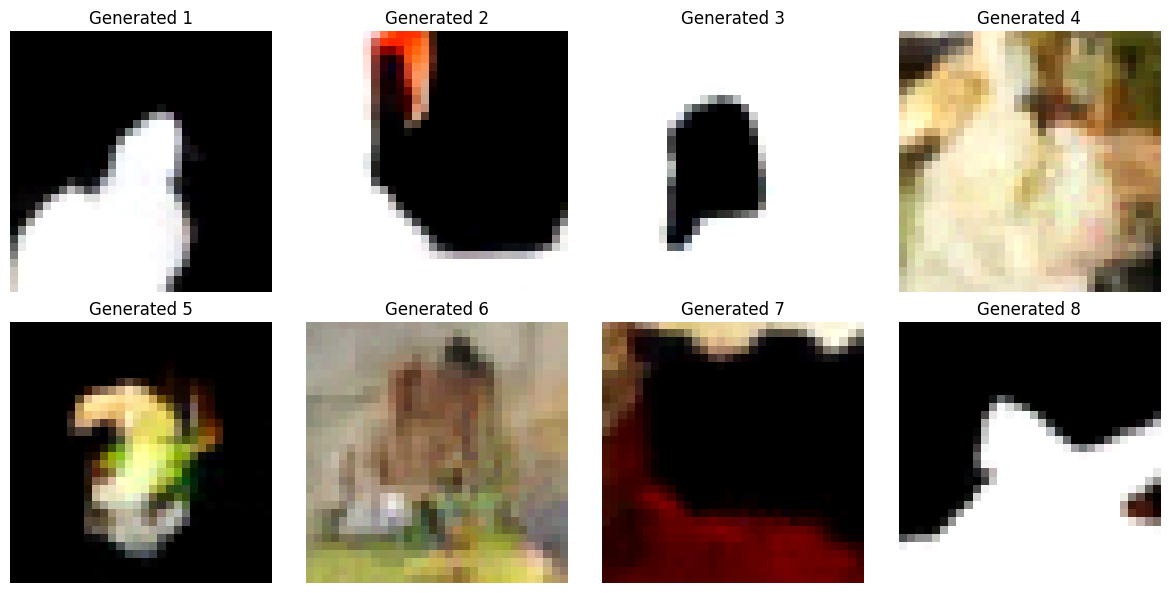

In [20]:
# Generate images
print("Generating images...")
generated = sample(model, (8, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device)

# Denormalize for visualization
generated = (generated + 1) / 2  # From [-1, 1] to [0, 1]
generated = torch.clamp(generated, 0, 1)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = generated[i].cpu().numpy()
    
    # Handle different channel formats
    if IMAGE_CHANNELS == 1:
        # Grayscale: [1, H, W] -> [H, W]
        img = img.squeeze(0)
        axes[i].imshow(img, cmap='gray')
    else:
        # RGB: [C, H, W] -> [H, W, C]
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
    
    axes[i].axis('off')
    axes[i].set_title(f'Generated {i+1}')

plt.tight_layout()
plt.show()


## 8. Visualize Training Loss


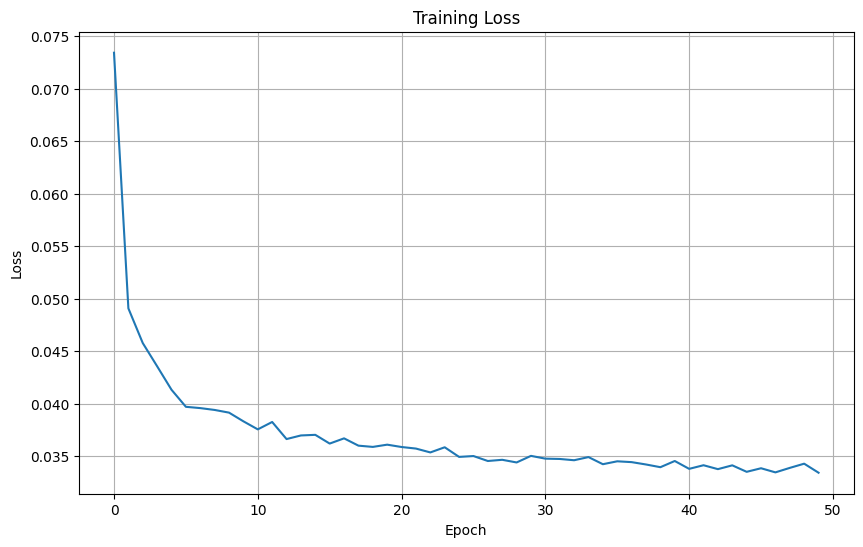

In [21]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


## 9. Visualize Forward Diffusion Process


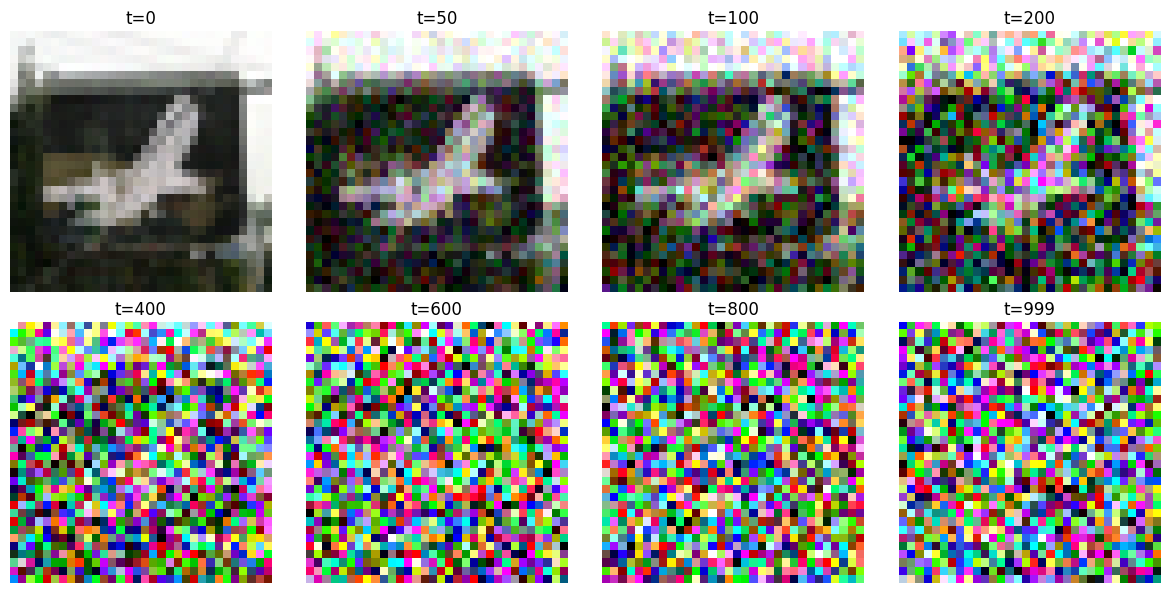

In [22]:
# Visualize how noise is added over time
test_image, _ = next(iter(loader))
test_image = test_image[0:1].to(device)

timesteps_to_show = [0, 50, 100, 200, 400, 600, 800, 999]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    noisy = q_sample(test_image, t_tensor)
    img = (noisy[0].cpu().numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    
    # Handle different channel formats
    if IMAGE_CHANNELS == 1:
        # Grayscale: [1, H, W] -> [H, W]
        img = img.squeeze(0)
        axes[idx].imshow(img, cmap='gray')
    else:
        # RGB: [C, H, W] -> [H, W, C]
        img = img.transpose(1, 2, 0)
        axes[idx].imshow(img)
    
    axes[idx].axis('off')
    axes[idx].set_title(f't={t}')

plt.tight_layout()
plt.show()


## Summary

You've successfully implemented a **Diffusion Model from scratch**! 

### What you built:
- ✅ **Noise schedule** (beta, alpha, alpha_bar)
- ✅ **Forward diffusion** (adding noise)
- ✅ **U-Net architecture** with time embeddings
- ✅ **Training loop** (noise prediction)
- ✅ **Sampling** (reverse diffusion for generation)

### Key Concepts:
- The model learns to **predict noise** at each timestep
- During generation, we **remove predicted noise** step by step
- This is the foundation of **Stable Diffusion** and other modern generative models!

### Next Steps:
- Train for more epochs for better quality
- Add self-attention layers
- Try on larger images (CIFAR-10, CelebA)
- Implement Latent Diffusion (VAE encoder/decoder)
